# Creating and Valuing a CDS Option

In [18]:
# This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; 
# without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  
# See the license for more details.

Example CDS Valuation and comparison with market standard ISDA model on Markit website

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils.FinDate import FinDate
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.finutils.FinFrequency import FinFrequencyTypes
from financepy.finutils.FinMath import ONE_MILLION
from financepy.products.libor.FinLiborDeposit import FinLiborDeposit
from financepy.products.libor.FinLiborSwap import FinLiborSwap
from financepy.market.curves.FinLiborCurve import FinLiborCurve
from financepy.products.credit.FinCDS import FinCDS
from financepy.market.curves.FinCDSCurve import FinCDSCurve
from financepy.products.credit.FinCDSOption import FinCDSOption

In [3]:
tradeDate = FinDate(2014, 2, 5)
settlementDate = tradeDate.addDays(1)

## Build Libor Curve

In [4]:
depos = []
dcType = FinDayCountTypes.THIRTY_E_360_ISDA
fixedFreq = FinFrequencyTypes.SEMI_ANNUAL
swap1 = FinLiborSwap(settlementDate,"1Y",0.0502,fixedFreq,dcType)
swap2 = FinLiborSwap(settlementDate,"2Y",0.0502,fixedFreq,dcType)
swap3 = FinLiborSwap(settlementDate,"3Y",0.0501,fixedFreq,dcType)
swap4 = FinLiborSwap(settlementDate,"4Y",0.0502,fixedFreq,dcType)
swap5 = FinLiborSwap(settlementDate,"5Y",0.0501,fixedFreq,dcType)
swaps = [swap1,swap2,swap3,swap4,swap5]

liborCurve = FinLiborCurve("USD_LIBOR", settlementDate, depos, [], swaps)

## Build a CDS Curve

In [5]:
cdsFlatSpread = 0.0100

In [6]:
cds1 = FinCDS(settlementDate, "1Y", cdsFlatSpread)
cds2 = FinCDS(settlementDate, "2Y", cdsFlatSpread)
cds3 = FinCDS(settlementDate, "3Y", cdsFlatSpread)
cds4 = FinCDS(settlementDate, "4Y", cdsFlatSpread)
cds5 = FinCDS(settlementDate, "5Y", cdsFlatSpread)
cds6 = FinCDS(settlementDate, "7Y", cdsFlatSpread)
cds7 = FinCDS(settlementDate, "10Y", cdsFlatSpread)
cds8 = FinCDS(settlementDate, "15Y", cdsFlatSpread)

In [7]:
cdss = [cds1, cds2, cds3, cds4, cds5, cds6, cds7, cds8]

In [8]:
recoveryRate = 0.40

In [9]:
issuerCurve = FinCDSCurve(settlementDate, cdss, liborCurve, recoveryRate)

## CDS Option

In [10]:
stepInDate = tradeDate.addDays(1)
valuationDate = stepInDate
expiryDate = FinDate(20, 3, 2014)
maturityDate = FinDate(20, 6, 2019)    

In [11]:
cdsCoupon = 0.01
volatility = 0.3    
notional = ONE_MILLION
longProtection = True

In [12]:
strikes = np.linspace(80,120,21)/10000
longValues = []
shortValues = []

# Long Protection
for strike in strikes:
    cdsOption = FinCDSOption(expiryDate, maturityDate, strike, notional, True)
    v = cdsOption.value(valuationDate, issuerCurve, volatility)
    longValues.append(v)
    
# Short Protection
for strike in strikes:
    cdsOption = FinCDSOption(expiryDate, maturityDate, strike, notional, False)
    v = cdsOption.value(valuationDate, issuerCurve, volatility)
    shortValues.append(v)
    

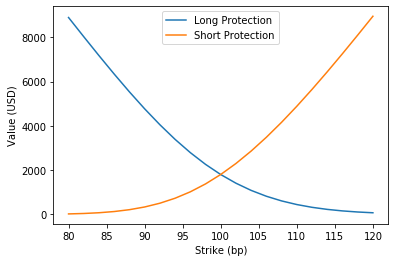

In [13]:
plt.plot(strikes*10000, longValues, label="Long Protection")
plt.plot(strikes*10000, shortValues, label="Short Protection")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend()

## Put Call Parity

Check that put-call parity holds by comparing a long protection minus a short protection option to a forward starting long protection CDS

In [14]:
fwdValues = []

for strike in strikes:
    fwdCDSContract = FinCDS(expiryDate, maturityDate, strike, notional, True)
    v = fwdCDSContract.value(valuationDate, issuerCurve, recoveryRate)
    fwdValues.append(v['full_pv'])

In [15]:
callMinusPut = np.array(longValues) - np.array(shortValues)

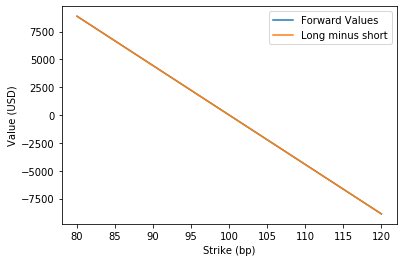

In [16]:
plt.plot(strikes*10000, fwdValues, label="Forward Values")
plt.plot(strikes*10000, callMinusPut, label="Long minus short")
plt.xlabel("Strike (bp)")
plt.ylabel("Value (USD)")
plt.legend()

## Implied Volatility

Let us just check that we can recover the input volatility

In [17]:
for strike in np.linspace(100, 200, 21):
    cdsOption = FinCDSOption(expiryDate, maturityDate, strike / 10000.0,  notional, False)
    v = cdsOption.value(valuationDate, issuerCurve, volatility)
    vol = cdsOption.impliedVolatility(valuationDate, issuerCurve, v)
    print("%10d %12.5f %12.7f" %(strike, v, vol))

       100   1802.09175    0.3000000
       105   3165.44191    0.3000000
       110   4885.22437    0.3000000
       115   6848.88287    0.3000000
       120   8952.61301    0.3000000
       125  11125.36836    0.3000000
       130  13327.86325    0.3000000
       135  15541.74358    0.3000000
       140  17759.55154    0.3000000
       145  19978.59537    0.3000000
       150  22197.99770    0.3000000
       155  24417.49683    0.3000000
       160  26637.02047    0.3000000
       165  28856.54999    0.3000000
       170  31076.08084    0.3000000
       175  33295.61198    0.3000000
       180  35515.14319    0.3000000
       185  37734.67440    0.3000000
       190  39954.20562    0.3000000
       195  42173.73684    0.3000000
       200  44393.26806    0.3000000


Copyright (c) 2020 Dominic O'Kane